In [ ]:
!pip install rasterio
!pip install geopandas

In [2]:
%pylab inline
import geopandas as gpd
import rasterio as rio
import rasterio.plot as rplot
import itertools
import rasterio.mask as mask
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Root Directory
Image_Segmentation_Path = '/content/drive/My Drive/Image Segmentation/'

# Inputs/Sources
Processed_DEMs_Path = Image_Segmentation_Path + "Processed DEMs/"
high_dem_interpolated = Processed_DEMs_Path + "high_dem_interpolated.tif"
mounds_f = Image_Segmentation_Path + "polygons/mounds.shp"
vents_f = Image_Segmentation_Path + "points/vent_points.shp"

#Outputs/Destinations
annotation_file = Processed_DEMs_Path + "annotated.tif"

# PNGs for the report 
PNG_Path = Image_Segmentation_Path + "PNG/"

not valid 56
not valid 92
not valid 100
not valid 163
not valid 200
not valid 329
not valid 330


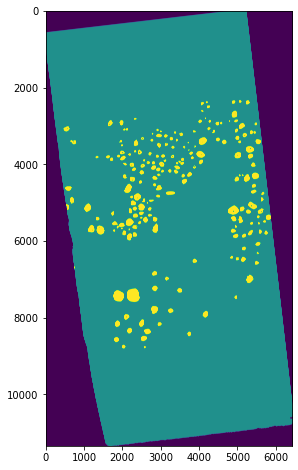

In [5]:
dsource= rio.open(high_dem_interpolated)
dtm = dsource.read()
meta = dsource.meta
profile =dsource.profile
data = gpd.read_file(mounds_f)
toremove = []
for id, gg in enumerate(data.geometry):
    if not gg.is_valid:
        print(f"not valid {id}")
        toremove.append(id)

data = data.drop(toremove)
data.drop_duplicates(inplace=True)

simple_mounds = data[data.Morpho == "simple"]
### Reprojecting the labels coordinate system to that of the original DEM. 
mounds_corrected  =simple_mounds.to_crs(meta["crs"])

### Masking the labels. 0 for non mounds, 1 for mounds. Can be used for segmentation. 

out_img, out_transform =mask.mask(dataset=dsource, shapes = mounds_corrected.geometry, nodata=np.nan) 
# do the crop 
out_img = out_img[0]
nodata = meta["nodata"] 
invalid_elevation = dtm[0] == nodata 
isnan = np.isnan(out_img) 
out_img[isnan] = 0
out_img[~isnan] = 1
out_img[invalid_elevation] = -1 # overall mask 0 non mounds, 1 mounds, -1 unknown
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.imshow(out_img)
fig.savefig(PNG_Path+"Annotated.png")

In [6]:
with rio.open(annotation_file, 'w', **profile) as dest: 
  dest.write_band(1, out_img)

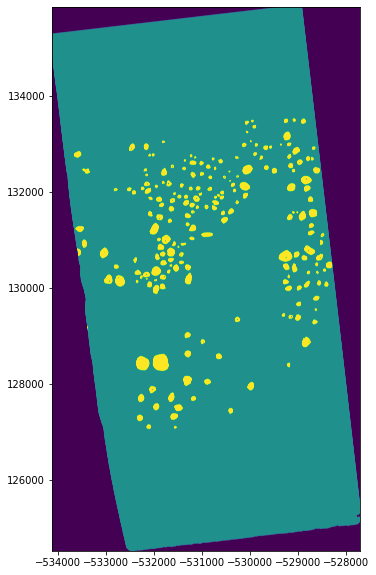

In [7]:
annotated = rio.open(annotation_file)
fig, ax = plt.subplots(1,1, figsize=(10,10))
rplot.show(annotated, fig)